In [2]:
import numpy as np
import math
import pandas as pd
# input material properties

# calcualte alpha

# calcualte teh melt pool depth

# return pi1, pi2 

# heat of fusion for alu is 10.79 kJ/mol ???
# or 4*10^5 J/kg

# t0 will be 300K
# t_solid will be 580 + 273 K = 853 K

# rho = 2700 kg/m^3

# Cp = 0.915 kJ/kgK

# diffusivity = 9.7 * 10^-5 m^2/s

# lets take the absorptivity as 0.3 the same as in the paper
# assume that lasre power is at least 100W set the absorbptivity to 0.4 accoridn to the material paper


# we have: 
# maybe absorptivity, power, rho, cp, T_solid, T_0, hf, Diffusivity, scan_speed, beam_diameter

# ask abou the beam diameter, absorptivity

# we dont have:
# 


def H_star(absorptivity=0.3, power=400.0, rho=2500.0, Cp=915.0, T_solid=853.0, T_0=300.0, hf=40000.0, Diffusivity=0.000097, scan_speed=0.5, beam_diameter=0.0001):

    H = (4 * absorptivity * power)/(np.pi*rho*(Cp*(T_solid - T_0) + hf) * np.sqrt(Diffusivity * scan_speed * beam_diameter**3))

    #write the values for the variables in a csv file 
        

    return H

test_1 = H_star()

print(test_1)



# write a loop to go through power bewtween 50 and 400W, scan speed between 0.750 and 3.0

#H * fourier number * absorptivity

df = pd.DataFrame(columns=['Power', 'Scan Speed', 'H_star'])

for power in np.linspace(50, 400, 20):
    for scan_speed in np.linspace(0.5, 3.0, 20):
        H_star_val = H_star(power=power, scan_speed=scan_speed)
        #*100*0.9*0.3
        # reward = ((-0.1*(H_star_val - 150)**2) - 1000*((scan_speed - 3)**2) - 0.1*(power - 300)**2)
        # making the polot more legible, change for actualy reward function
        reward = H_star_val

        df = df._append({'Power': power, 'Scan Speed': scan_speed, 'H_star': reward}, ignore_index=True)

print(df)

# write all the values for the variables in a csv file
df.to_csv('H_star_values.csv')




16.072810378421977
     Power  Scan Speed    H_star
0     50.0    0.500000  2.009101
1     50.0    0.631579  1.787611
2     50.0    0.763158  1.626221
3     50.0    0.894737  1.501894
4     50.0    1.026316  1.402317
..     ...         ...       ...
395  400.0    2.473684  7.226112
396  400.0    2.605263  7.041270
397  400.0    2.736842  6.869924
398  400.0    2.868421  6.710508
399  400.0    3.000000  6.561697

[400 rows x 3 columns]


/tmp/ipykernel_3079/2374035586.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append({'Power': power, 'Scan Speed': scan_speed, 'H_star': reward}, ignore_index=True)


In [3]:
df.head()

,Power,Scan Speed,H_star
0,50.0,0.500000,2.009101
1,50.0,0.631579,1.787611
2,50.0,0.763158,1.626221
3,50.0,0.894737,1.501894
4,50.0,1.026316,1.402317


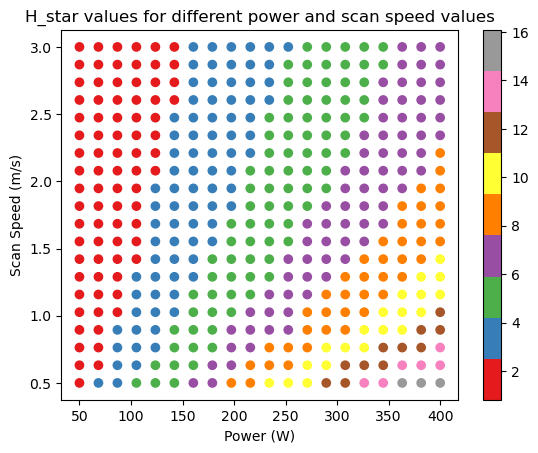

In [4]:
# plot the data
#use the H_star values as the color map

import matplotlib.pyplot as plt

plt.scatter(df['Power'], df['Scan Speed'], c=df['H_star'], cmap='Set1')
plt.colorbar()
plt.xlabel('Power (W)')
plt.ylabel('Scan Speed (m/s)')
plt.title('H_star values for different power and scan speed values')

        

plt.show()

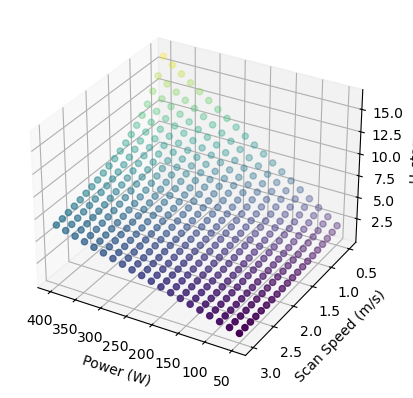

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['Power'], df['Scan Speed'], df['H_star'], c=df['H_star'])
ax.set_xlabel('Power (W)')
ax.set_ylabel('Scan Speed (m/s)')
ax.set_zlabel('H_star')
ax.view_init(30, 120)
plt.show()




In [6]:
# fourier number for our aluminum
def Fourier(alpha=0.0000097, t=0.001, L=0.001):
    return alpha*t/L**2


SF = np.sqrt(Fourier())

print(SF)

0.09848857801796106


In [7]:
# def D_Depth(H):
#     a = 0.0152
#     b = -0.117
#     c = 1.215
#     # quadratic equation from the enthalpy paper
#     D = a*H**2 + b*H + c
#     return D


# def D_Width(H):
#     a = 0.00053
#     b = 0.158
#     c = 0.207
#     # quadratic equation from the enthalpy paper
#     W = a*H**2 + b*H + c
#     return W


In [8]:
# def Melt_mode(H):
#     Melt_mode = D_Depth(H) / D_Width(H)
#     #print(D_Depth(H), D_Width(H), Melt_mode)
#     if Melt_mode > 1:
#         #print("possible keyholes")
#         MM = 1
#     else:
#         #print("no keyholes")
#         MM = 0
#     return MM

In [9]:
# for i in range(50):
#     print(f"i={i}")
#     print(Melt_mode(i))


In [10]:
power = np.linspace(50, 400, 20)
scan_speed = np.linspace(0.1, 3.0, 20)




In [11]:
# read_depth = 0.00001*D_Depth(18)
# print(read_depth)

In [12]:
# H * 10 to get melt pool in micro meters


In [13]:
# reward function
H = H_star()
Scan_speed = 0.5
reward = (-0.01*(H - 150)**2) - 100*((scan_speed - 3)**4)
print(reward)

[-7252.1749212  -5876.64550192 -4712.23501896 -3736.14913986
 -2926.89606545 -2264.28652984 -1729.43380043 -1304.75367788
  -973.96449617  -722.08712253  -535.44495749  -401.66393487
  -309.67252174  -249.70171849  -213.28505878  -193.25860955
  -183.76097103  -180.23327672  -179.41919342  -179.3649212 ]


  0%|          | 0/10000000 [00:00<?, ?it/s]

100%|██████████| 10000000/10000000 [04:47<00:00, 34799.30it/s]


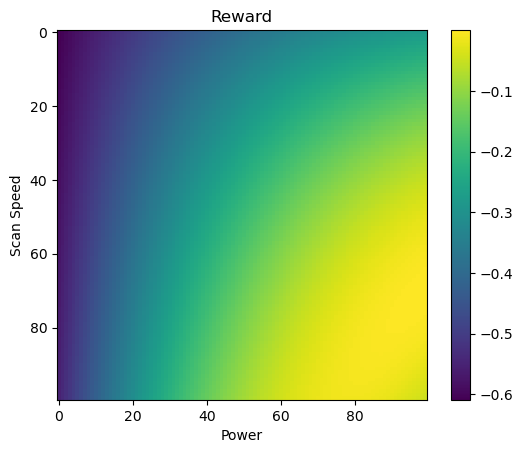

In [14]:
# q learning, table based

# state space: power, scan speed

# action space: power up, power down, power same, scan speed up, scan speed down, scan speed same

# H = (4 * self.absorptivity * power) * 100 * 0.9 * 0.3 / (np.pi * self.rho * (self.Cp * (self.T_solid - self.T_0) + self.hf) * np.sqrt(self.Diffusivity * scan_speed * self.beam_diameter**3))

# reward function = -0.01*(H_star(power, scan_speed) - 150)**2 - 100*((scan_speed - 3)**4)

# power range  = np.linsapce(50, 400, 100)

# scan speed range  = np.linsapce(0.2, 3.0, 100)

# explore the state space and action space

# start with a random state, random action

# update the q table

# repeat the process

# until the q table converges

# use the q table to find the optimal power and scan speed values

# plot the optimal power and scan speed values

# plot the H_star values for the optimal power and scan speed values

# intruduce a chance to pick a random action instead of the optimal action

# max epochs = 1000


import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


class QLearning:
    def __init__(self):
        self.alpha = 0.1
        self.gamma = 0.6
        self.epsilon = 0.1
        self.q_table = np.zeros((100, 100, 4))
        self.power_range = np.linspace(50.0, 400.0, 100)
        self.scan_speed_range = np.linspace(0.2, 3.0, 100)
        self.epochs = 10000000
        self.absorptivity = 0.3
        self.rho = 2500.0
        self.Cp = 915.0
        self.T_solid = 853.0
        self.T_0 = 300.0
        self.hf = 40000.0
        self.Diffusivity = 0.000097
        self.beam_diameter = 0.0001
        self.start_reward = -1
        self.lr = 0.1

    def H_star(self, power, scan_speed):
        H = ((4 * self.absorptivity * power ) / (np.pi * self.rho * (self.Cp * (self.T_solid - self.T_0) + self.hf) * np.sqrt(self.Diffusivity * (scan_speed/10) * self.beam_diameter**3)))
        return H
    
    def reward(self, power, scan_speed):
        
        # reward = (-0.01*(H_star(power, scan_speed) - 150)**2) - 1000*((scan_speed - 3)**2) - 0.1*(power - 300)**2
        #reward = (-0.01*(H_star(power, scan_speed) - 150)**2) - 1000*((scan_speed - 3)**2) - 0.1*(power - 300)**2
        # sigmoid function
        #reward = 1/(1 + np.exp(-(-0.01*(H_star(power, scan_speed) - 150)**2) - 1000*((scan_speed - 3)**2) - 0.1*(power - 300)**2))
        # tanh function
        reward = (-((H_star(power, scan_speed)* 0.3*0.9*100)-120)**2 - 1000*((scan_speed - 3)**2))/36000
        #print(power, scan_speed, reward)
        return reward
    
    def get_state(self, power, scan_speed):
        power_index = np.argmin(np.abs(self.power_range - power))
        scan_speed_index = np.argmin(np.abs(self.scan_speed_range - scan_speed))
        return power_index, scan_speed_index
    
    def get_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            action = np.random.choice(4)
            #print(action)
        else:
            # action = int((np.random.uniform(0, 1))*4)
            # print(action)
            action = np.argmax(self.q_table[state])
        return action
    
    def update_q_table(self, state, action, reward, next_state):
        predict = self.q_table[state][action]
        target = reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state][action] += self.alpha * (target - predict)

    def train(self):
        reward = self.start_reward
        for epoch in tqdm(range(self.epochs)):
            power = np.random.choice(self.power_range)
            scan_speed = np.random.choice(self.scan_speed_range)
            state = self.get_state(power, scan_speed)
            action = self.get_action(state)
            
            if power < 50 or scan_speed < 0.2:
                reward = -1
            else:
                reward = (self.reward(power, scan_speed)*(1-self.lr) + (self.lr)*reward)

            if action == 0:
                power = min(power + 1, self.power_range[-1])
            elif action == 1:
                power = max(power - 1, self.power_range[0])
            elif action == 2:
                scan_speed = min(scan_speed + 0.1, self.scan_speed_range[-1])
            elif action == 3:
                scan_speed = max(scan_speed - 0.1, self.scan_speed_range[0])
            next_state = self.get_state(power, scan_speed)
            self.update_q_table(state, action, reward, next_state)
            # if epoch % 100000 == 0:
            #     print(power, scan_speed, epoch)
        return self.q_table
    
    def optimal_policy(self):
        optimal_policy = np.zeros((100, 100))
        for i in range(100):
            for j in range(100):
                optimal_policy[i][j] = np.argmax(self.q_table[i][j])
        return optimal_policy
    
    def plot_optimal_policy(self):
        optimal_policy = self.optimal_policy()
        plt.imshow(optimal_policy)
        plt.colorbar()
        plt.xlabel('Power / 4')
        plt.ylabel('Scan Speed * 33')
        plt.title('Optimal Policy')
        plt.show()

    def plot_reward(self):
        reward = np.zeros((100, 100))
        for i in range(100):
            for j in range(100):
                reward[i][j] = self.reward(self.power_range[i], self.scan_speed_range[j])
        plt.imshow(reward)
        plt.colorbar()
        plt.xlabel('Power')
        plt.ylabel('Scan Speed')
        plt.title('Reward')
        plt.show()

ql = QLearning()
q_table = ql.train()
#ql.plot_optimal_policy()
ql.plot_reward()






In [15]:
# # print the values assossiated with the highest reward
# print(np.max(q_table))

# # print the power and scan speed values assossiated with the highest reward
# print(np.argmax(q_table))
q_copy = q_table.copy()

#location of the highest reward
recc_power, recc_ss, R = np.unravel_index(np.argmax(q_copy, axis=None), q_copy.shape)
print(f"The recommended power is {recc_power*4} and the recommended scan speed is {recc_ss/33:.2f}")
#location of the second highest reward
q_copy[recc_power, recc_ss] = -100000
recc_power, recc_ss, R = np.unravel_index(np.argmax(q_copy, axis=None), q_copy.shape)
print(f"The second recommended power is {recc_power*4} and the second recommended scan speed is {recc_ss/33:.2f}")
#location of the third highest reward
q_copy[recc_power, recc_ss] = -100000
recc_power, recc_ss, R = np.unravel_index(np.argmax(q_copy, axis=None), q_copy.shape)
print(f"The third recommended power is {recc_power*4} and the third recommended scan speed is {recc_ss/33:.2f}")

# highest reward
print(np.max(q_table))
print(np.min(q_table))






The recommended power is 276 and the recommended scan speed is 3.00
The second recommended power is 272 and the second recommended scan speed is 2.97
The third recommended power is 304 and the third recommended scan speed is 2.88
-0.053341110091653925
-1.3901499213043946


In [17]:
# save the q table and the optimal policy as a tiff file
import tifffile as tiff

tiff.imwrite('q_table.tiff', q_table)
tiff.imwrite('optimal_policy.tiff', ql.optimal_policy())

print("q_table and optimal_policy saved as tiff files")


q_table and optimal_policy saved as tiff files


(100, 100, 4)